In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymysql

In [110]:
# Functions

## given two curve a, b, then return the inversection point of two curves
def FindTheBuyPoint(a, b):
    buyPoint = np.argwhere(np.diff(np.sign(a - b)) > 0).reshape(-1) + 0
    return buyPoint

def FindTheSellPoint(a, b):
    sellPoint = np.argwhere(np.diff(np.sign(a - b)) < 0).reshape(-1) + 0
    return sellPoint

def GetDataFromDB(ip, userName, psw, tableName, sql):
    try:
        db = pymysql.connect(ip, userName, psw, tableName)
    except:
        print ("Error: unable to connect to DB")
        
    #create a cursor
    cursor = db.cursor()

    try:
        cursor.execute(sql)
        results = cursor.fetchall()
    except:
        print ("Error: unable to fetch data from DB")
    
    db.close()
    
    return results

def SMA(data, period):
    if (type(data) == pd.core.series.Series):
        return data.rolling(window = period).mean()
    else:
        print ("Error: Wrong input, SMA(pandas.core.series.Series, integer)")
        
def EMA(data, period):
    if (type(data) == pd.core.series.Series):
        return data.ewm(span = period, adjust = False).mean()
    else:
        print ("Error: Wrong input, EMA(pandas.core.series.Series, integer)")
        
def RSI(data, period):
    if (type(data) == pd.core.series.Series):
        delta = data.diff()
        up, down = delta.copy(), delta.copy()

        up[up < 0] = 0
        down[down > 0] = 0
        down = abs(down)

        Up = SMA(up, period)

        Up = Up.fillna(0)
        for i in range(period + 1,len(Up)):
            Up[i] = (Up[i - 1] * (period - 1) + up[i]) / period

        Down = SMA(down, period)
        Down = Down.fillna(0)
        for i in range(period + 1,len(Down)):
            Down[i] = (Down[i - 1] * (period - 1) + down[i]) / period


        rsi = 100 * (Up / (Up + Down))
        rsi = rsi.fillna(0)
        return rsi
    else:
        print ("Error: Wrong input, RSI(pandas.core.series.Series, integer)")
        
def MACD(data, period = []):
    if (type(data) == pd.core.frame.DataFrame and len(period) == 3):   
        di = (data['High'] + data['Low'] + 2.0 * data['Close']) / 4.0
        ema12 = SMA(di, period[0])
        ema12 = ema12.fillna(0)
        for i in range(period[0] + 1, len(ema12)):
            ema12[i] = (ema12[i - 1] * (period[0] - 1) + di[i] * 2.0) / (period[0] + 1)
    
        ema26 = SMA(di, period[1])
        ema26 = ema26.fillna(0)
        for i in range(period[1] + 1, len(ema26)):
            ema26[i] = (ema26[i - 1] * (period[1] - 1) + di[i] * 2.0) / (period[1] + 1)
    
        dif = ema12 - ema26

        dem = SMA(dif, period[2])
        dem = dem.fillna(0)
        for i in range(period[2] + 1, len(dem)):
            dem[i] = (dem[i - 1] * (period[2] - 1) + dif[i] * 2.0) / (period[2] + 1)
        return {'dif':dif, 'dem':dem}
    else:
        if(type(data) == pd.core.frame.DataFrame):
            print ("Error: Wrong input, MACD(pandas.core.frame.DataFrame, list of integer)")
        elif(len(period) == 3):
            print ("Error: number of content in list do not equal to 3")
            
def KD(data):
    close = data['Close'].copy()
    for i in range(0,9):
        close[i] = 0

    data['RSV'] = (( data['Close'] - data['Low'].rolling(window = 9).min()) / (data['High'].rolling(window = 9).max() - data['Low'].rolling(window = 9).min()))
    data['RSV'] = data['RSV'].fillna(0)

    result = {
        'K9':[0],
        'D9':[0]
    }

    #calculate everyday's KD
    for i in range(1, len(data.index)):
        K9_value = (1.0/3.0) * data['RSV'][i] + (2.0 / 3.0) * result['K9'][i - 1]
        result['K9'].append(K9_value)
        D9_value = (2.0/3.0) * result['D9'][i - 1] + (1.0 / 3.0) * result['K9'][i]
        result['D9'].append(D9_value)
        
    return result

In [126]:
# define a class - indicators, which contains all indicators that calculate by the data
class Indicators:
    data = pd.DataFrame()
    EMA = pd.DataFrame()
    SMA = pd.DataFrame()
    RSI = pd.DataFrame()
    KD = pd.DataFrame()
    MACD = pd.DataFrame()
    
    def __init__(self, inputData):
        self.data = inputData
        self.SMA = self.setSMA([5, 20, 100])
        self.EMA = self.setEMA([5, 20, 100])
        self.RSI = self.setRSI(14)
        self.KD = self.setKD()
        self.MACD = self.setMACD([12, 26, 9])
    
    def setSMA(self, periods = []):
        smaResults = []
        for i in range(len(periods)):
            if (type(periods[i]) != int):
                print ("Error: inputData is not a list of integer")
                return
            else:
                smaResults.append(SMA(self.data['Close'], periods[i]))
                
        return pd.DataFrame(dict((("SMA" + str(periods[i])), smaResults[i]) for i in range(0, len(smaResults))))
    
    def getSMA(self):
        return self.SMA
    
    def setEMA(self, periods = []):
        emaResults = []
        for i in range(len(periods)):
            if (type(periods[i]) != int):
                print ("Error: inputData is not a list of integer")
                return
            else:
                emaResults.append(EMA(self.data['Close'], periods[i]))
                
        return pd.DataFrame(dict((("EMA" + str(periods[i])), emaResults[i]) for i in range(0, len(emaResults))))
    
    def getEMA(self):
        return self.EMA
    
    def setRSI(self, period):
        if (type(period) != int):
            print ("Error: inputData is not an integer")
            return
        
        rsiResults = RSI(self.data['Close'], period)
        return pd.DataFrame({"RSI": list(rsiResults)})
    
    def getRSI(self):
        return self.RSI
    
    def setKD(self):
        kdResults = KD(self.data)
        return pd.DataFrame(kdResults)
    
    def getKD(self):
        return self.KD
    
    def setMACD(self, periods = []):
        macdResults = []
        for i in range(len(periods)):
            if (type(periods[i]) != int):
                print ("Error: inputData is not a list of integer")
                return
        macdResults = MACD(self.data, periods)
        return pd.DataFrame(macdResults)
    
    def getMACD(self):
        return self.MACD

In [129]:
#get the close price from DB

try:
    sql = "SELECT LAST, DATE, HIGH, LOW FROM btc_usd ORDER BY DATE"
    results = GetDataFromDB("140.118.126.136", "123", "1234567890", "test", sql)
    Dates = []
    ClosePrices = []
    HighPrices = []
    LowPrices = []
    for i in range(len(results)):
        Dates.append(results[i][1])
        ClosePrices.append(results[i][0])
        HighPrices.append(results[i][2])
        LowPrices.append(results[i][3])
        
    CoinPriceData = {
        'Date' : Dates,
        'Close' : ClosePrices,
        'High' : HighPrices,
        'Low' : LowPrices
    }

    CoinPriceData = pd.DataFrame(CoinPriceData)
    
    print (CoinPriceData)
except:
    print ("Error: unable to fetch data from DB")

         Close                 Date       High        Low
0       505.00  2014-04-15 00:00:00    513.900    452.000
1       538.00  2014-04-16 00:00:00    547.000    495.000
2       508.00  2014-04-17 00:00:00    538.500    486.100
3       482.75  2014-04-18 00:00:00    509.000    474.250
4       507.50  2014-04-19 00:00:00    513.990    473.830
5       501.44  2014-04-20 00:00:00    517.995    492.200
6       497.00  2014-04-21 00:00:00    515.646    485.000
7       491.20  2014-04-22 00:00:00    506.000    488.800
8       490.03  2014-04-23 00:00:00    496.000    482.880
9       497.98  2014-04-24 00:00:00    498.840    480.160
10      463.79  2014-04-25 00:00:00    504.960    441.300
11      457.60  2014-04-26 00:00:00    469.190    449.800
12      445.00  2014-04-27 00:00:00    465.600    440.000
13      445.40  2014-04-28 00:00:00    450.000    423.110
14      445.54  2014-04-29 00:00:00    454.000    434.000
15      449.37  2014-04-30 00:00:00    453.600    432.000
16      460.10

In [128]:
# sma
sma5_close = SMA(CoinPriceData['Close'], 5)
sma20_close = SMA(CoinPriceData['Close'], 20)
sma100_close = SMA(CoinPriceData['Close'], 100)

indicators = Indicators(CoinPriceData)
print(indicators.getMACD())

             dem         dif
0       0.000000    0.000000
1       0.000000    0.000000
2       0.000000    0.000000
3       0.000000    0.000000
4       0.000000    0.000000
5       0.000000    0.000000
6       0.000000    0.000000
7       0.000000    0.000000
8       0.000000    0.000000
9       0.000000    0.000000
10      0.000000    0.000000
11     98.803838  494.019187
12    177.095657  490.262937
13    238.212638  482.680562
14    285.939744  476.848168
15    323.174870  472.115373
16    352.518805  469.894547
17    375.415429  467.001924
18    392.960361  463.140090
19    406.159304  458.955076
20    415.915995  454.942756
21    422.927647  450.974255
22    428.275061  449.664716
23    432.357077  448.685144
24    435.780071  449.472045
25    344.883614  -18.702212
26    272.288491  -18.092005
27    214.341707  -17.445429
28    168.237675  -16.178450
29    131.621922  -14.841090
...          ...         ...
1379 -214.418682  -19.409129
1380 -183.219647  -58.423507
1381 -155.4278

In [6]:
# ema
ema12_close = EMA(dfs_close['Close'], 12)
ema26_close = EMA(dfs_close['Close'], 26)

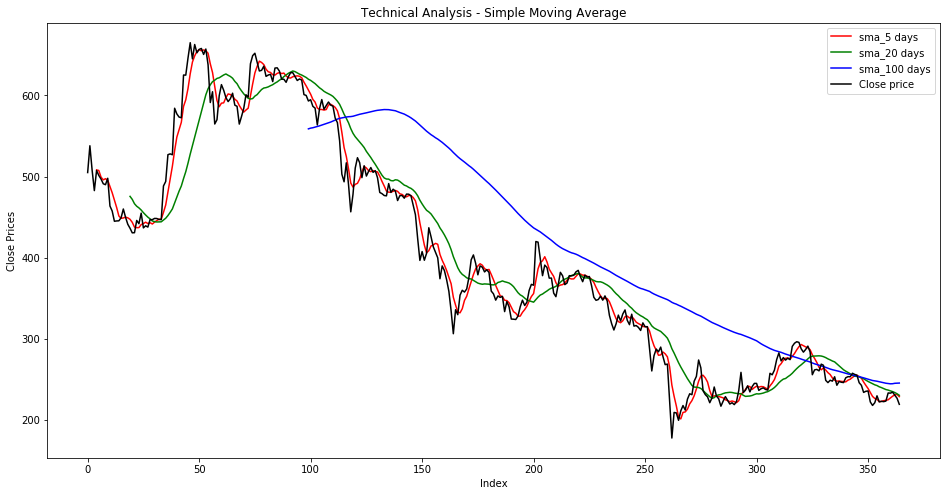

In [24]:
# Draw SMA curve
totalDate = 365
plt.figure(figsize = (16, 8))

x = [i for i in range(len(dfs_close.head(totalDate)))]
#x = list(dfs['Date'].head(totalDate))

## draw sma5
sma5c = [sma5_close[i] for i in range(len(sma5_close.head(totalDate)))]
plt.plot(x, sma5c, 'r', label = 'sma_5 days')

## draw sma20
sma20c = [sma20_close[i] for i in range(len(sma20_close.head(totalDate)))]
plt.plot(x, sma20c, 'g', label = 'sma_20 days')

## draw sma100
sma100c = [sma100_close[i] for i in range(len(sma100_close.head(totalDate)))]
plt.plot(x, sma100c, 'b', label = 'sma_100 days')

## draw all close prices
plt.plot(x, dfs_close['Close'].head(totalDate), label = 'Close price', color = 'k')

## draw the intersection points of three curves
# FindTheIntersection(sma5c, sma20c)

#p#icture setting
plt.xlabel("Index")
plt.ylabel("Close Prices")
plt.title("Technical Analysis - Simple Moving Average")
plt.legend(loc = 'upper right')

##show picture
plt.show()

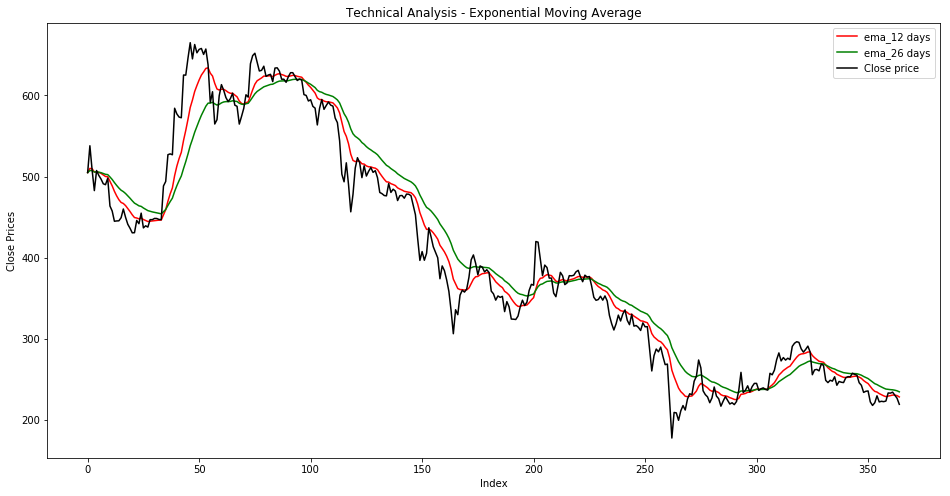

In [8]:
# Draw EMA curve
totalDate = 365
plt.figure(figsize = (16, 8))

x = [i for i in range(len(dfs_close.head(totalDate)))]
#x = list(dfs['Date'].head(totalDate))

##draw ema12
ema12c = [ema12_close[i] for i in range(len(ema12_close.head(totalDate)))]
plt.plot(x, ema12c, 'r', label = 'ema_12 days')

##draw ema26
ema26c = [ema26_close[i] for i in range(len(ema26_close.head(totalDate)))]
plt.plot(x, ema26c, 'g', label = 'ema_26 days')

##draw all close prices
plt.plot(x, dfs_close['Close'].head(totalDate), label = 'Close price', color = 'k')

#p#icture setting
plt.xlabel("Index")
plt.ylabel("Close Prices")
plt.title("Technical Analysis - Exponential Moving Average")
plt.legend(loc = 'upper right')

##show picture
plt.show()

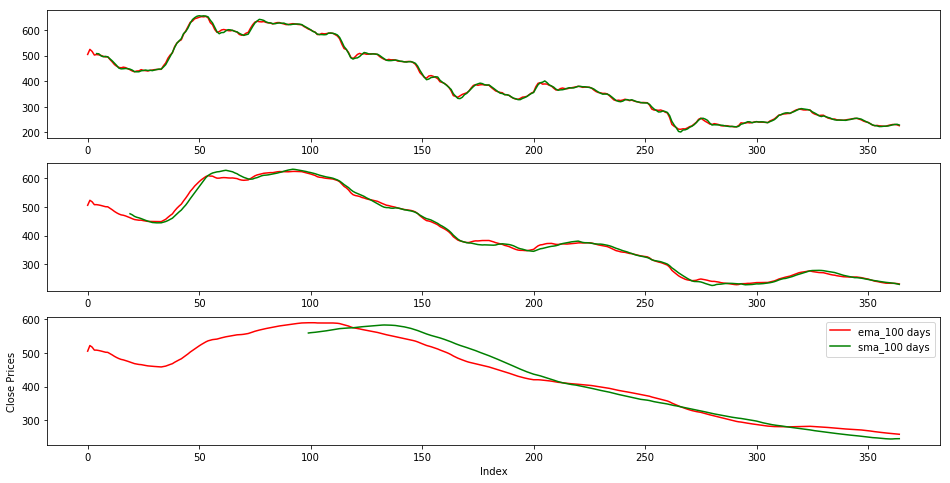

In [9]:
##compare EMA & SMA

# Draw EMA curve
totalDate = 365
plt.figure(figsize = (16, 8))
plt.subplot(3,1,1)
x = [i for i in range(len(dfs_close.head(totalDate)))]
#x = list(dfs['Date'].head(totalDate))

##draw ema5
ema5_close = dfs_close['Close'].ewm(span = 5).mean()
ema5c = [ema5_close[i] for i in range(len(ema5_close.head(totalDate)))]
plt.plot(x, ema5c, 'r', label = 'ema_5 days')

##draw sma5
plt.plot(x, sma5c, 'g', label = 'sma_5 days')

plt.subplot(3,1,2)

##draw ema20
ema20_close = dfs_close['Close'].ewm(span = 20).mean()
ema20c = [ema20_close[i] for i in range(len(ema20_close.head(totalDate)))]
plt.plot(x, ema20c, 'r', label = 'ema_20 days')

##draw sma20
plt.plot(x, sma20c, 'g', label = 'sma_20 days')

plt.subplot(3,1,3)

##draw ema100
ema100_close = dfs_close['Close'].ewm(span = 100).mean()
ema100c = [ema100_close[i] for i in range(len(ema100_close.head(totalDate)))]
plt.plot(x, ema100c, 'r', label = 'ema_100 days')

##draw sma100
plt.plot(x, sma100c, 'g', label = 'sma_100 days')

#picture setting
plt.xlabel("Index")
plt.ylabel("Close Prices")
plt.legend(loc = 'upper right')

##show picture
plt.show()

In [10]:
# get the High & Low Price from DB

#try to search all close prices in DB, and change the type to list
sql = "SELECT HIGH, LOW, DATE FROM btc_usd ORDER BY DATE"

try:
    results = GetDataFromDB("140.118.126.136", "123", "1234567890", "test", sql)
    
    Dates = []
    HighPrices = []
    LowPrices = []
    for i in range(len(results)):
        Dates.append(results[i][2])
        HighPrices.append(results[i][0])
        LowPrices.append(results[i][1])
    
    PriceData = {
        'Date' : Dates,
        'High' : HighPrices,
        'Low' : LowPrices
    }
except:
    print ("Error: unable to fetch data from DB")
    
dfs_HL = pd.DataFrame(PriceData)

In [12]:
# KD
#stockData_1101 = pd.read_csv(r"C:\Users\Mike\Desktop\1101.TW.csv", converters={"Open":float, "High":float, "Low":float, "Close":float})
#result = pd.DataFrame(stockData_1101)

data = KD(result)
dfs_KD = pd.DataFrame(data)

NameError: name 'result' is not defined

In [ ]:
# Draw the KD Curve
totalDate = 365
plt.figure(figsize = (16, 8))

x = [i for i in range(len(dfs_close.head(totalDate)))]
#x = list(dfs['Date'].head(totalDate))

## Draw K curve
Kc = [dfs_KD['K9'][i] for i in range(len(dfs_KD['K9'].head(totalDate)))]
plt.plot(x, Kc, 'b', label = 'K curve')

## Draw D curve
Dc = [dfs_KD['D9'][i] for i in range(len(dfs_KD['D9'].head(totalDate)))]
plt.plot(x, Dc, 'G', label = 'D curve')

##draw all intersection point of two curves
#buyPoint = FindTheBuyPoint(Dc, Kc)
#sellPoint = FindTheSellPoint(Dc, Kc)

#p#icture setting
plt.xlabel("Index")
plt.ylabel("Percentages")
plt.title("Technical Analysis - Stochastic Oscillator, KD")
plt.legend(loc = 'upper right')

##show picture
plt.show()

In [ ]:
# RSI
stockData_1101 = pd.read_csv(r"C:\Users\Mike\Desktop\1101.TW.csv", converters={"Open":float, "High":float, "Low":float, "Close":float})
result = pd.DataFrame(stockData_1101)

period = 14

rsi = RSI(result['Close'], period)

In [ ]:
# Draw RSI curve
totalDate = 365
plt.figure(figsize = (16, 8))

x = [i for i in range(len(dfs_close.tail(totalDate)))]
#x = list(dfs['Date'].head(totalDate))

## Draw rsi curve
rsic = plt.plot(x, rsi.tail(totalDate), 'k', label = 'RSI_curve')

#p#icture setting
plt.xlabel("Index")
plt.ylabel("Percentages")
plt.title("Technical Analysis - Relative Strength Index, RSI")
plt.legend(loc = 'upper right')

##show picture
plt.show()

In [ ]:
# MACD
stockData_1101 = pd.read_csv(r"C:\Users\Mike\Desktop\1101.TW.csv", converters={"Open":float, "High":float, "Low":float, "Close":float})
result = pd.DataFrame(stockData_1101)

dif, dem = MACD(result, [12,26,9])
# 小數點下兩位正確

In [ ]:
# draw MACD Curve
totalDate = 365
plt.figure(figsize = (16, 8))

x = [i for i in range(len(dfs_close.head(totalDate)))]
#x = list(dfs['Date'].head(totalDate))

## Draw DIF curve
difc = plt.plot(x, dif.head(totalDate), 'k', label = 'DIF_curve')

## Draw DEM curve
demc = plt.plot(x, dem.head(totalDate), 'b', label = 'DEM_curve')

## Draw the intersection points of two curves
buyPoint = FindTheBuyPoint(dif.head(totalDate), dem.head(totalDate))
sellPoint = FindTheSellPoint(dif.head(totalDate), dem.head(totalDate))
buyPoints = [buyPoint[i] for i in range(len(buyPoint))]
sellPoints = [sellPoint[i] for i in range(len(sellPoint))]

plt.plot(buyPoints, dem[buyPoints], "ro", label = "Buy Points")
plt.plot(sellPoints, dem[sellPoints], "go", label = "Sell Points")

#picture setting
plt.xlabel("Index")
plt.ylabel("Close Price")
plt.title("Technical Analysis - Moving Average Convergence / Divergence, MACD")
plt.legend(loc = 'upper right')

##show picture
plt.show()